In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src import train, generate, eval
from src.train import make_inference_model
from src.pipeline_util import load_bnn
from src.modules.config import read_config
import src.modules.plots as plots
from src.modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

#BASE_DIR = "../tests/dataset-tests/sineasy10-10k-s05/"
#PROFILE = "sineasy10-3x128-s05"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["EPOCHS"] = "500"
config["DEVICE"] = "cpu"
config["RERUNS"] = "1"
config["HIDDEN_FEATURES"] = "[32]"
config["LIKELIHOOD_SCALE"] = "0.3"
config["GUIDE_SCALE"] = "0.1"


dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["SIGMA"] = "0.3"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -1.8470730182375492 - 1.757711729724389
In Domain: (-10, 10)
Y-space: -1.7689647359468994 - 1.6668478296553313
Out Domain: (-20, 20)
Y-space: -1.583897416334067 - 1.8988115688755396


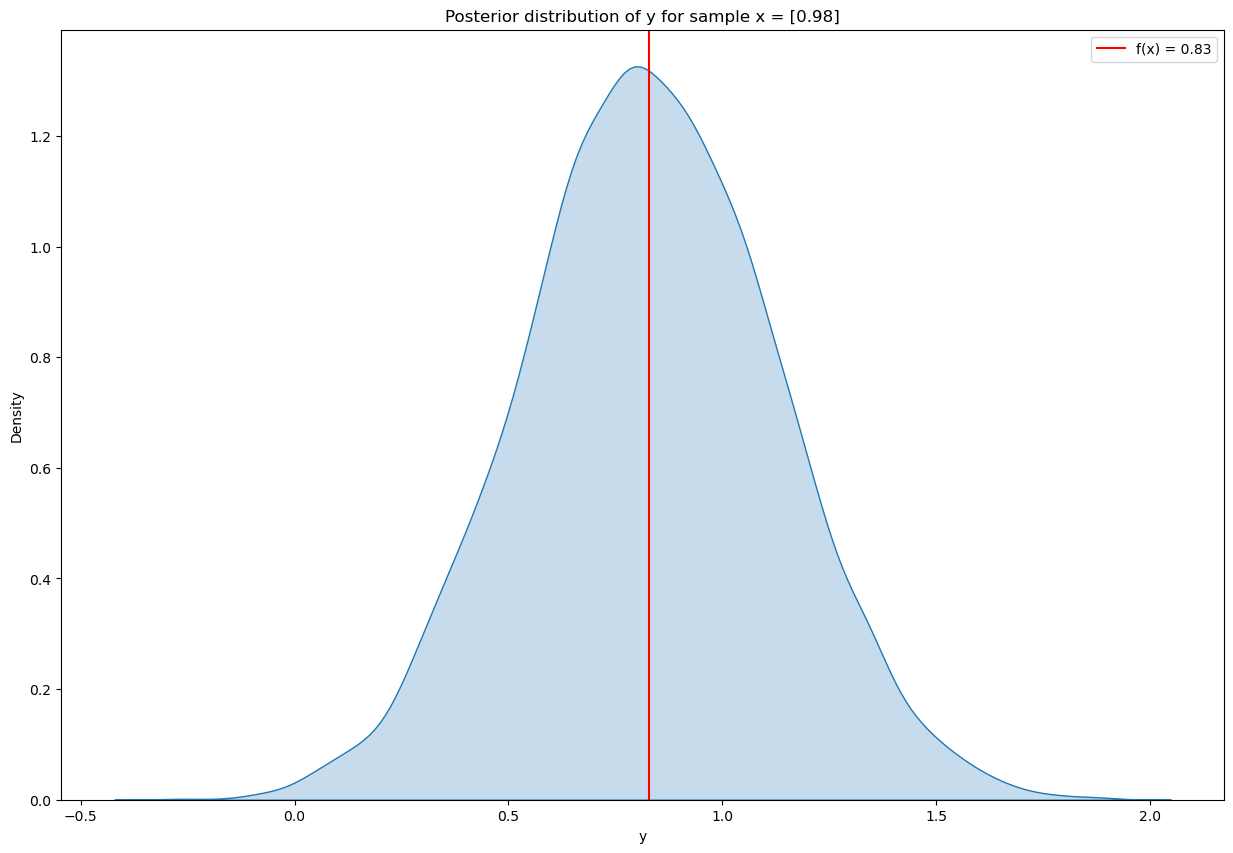

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


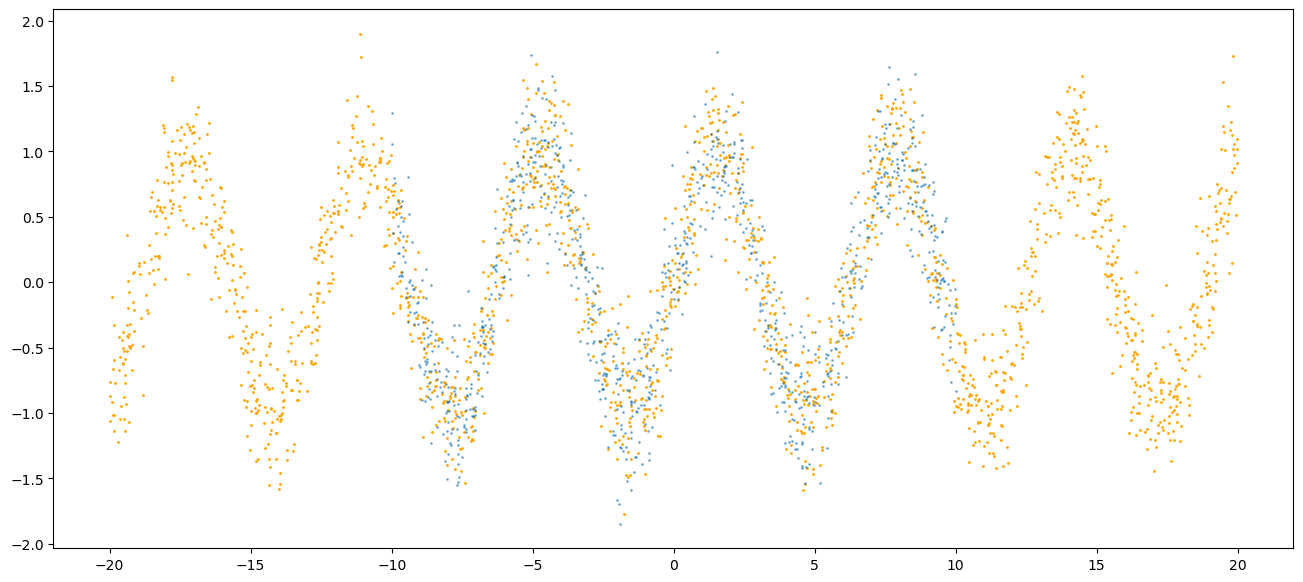

In [8]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
    plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [9]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

Cuda Devices: []
torch.Size([128, 1]) torch.Size([128, 1])
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.1 TRAIN_SIZE: 1000
Using device: cpu
===== Training profile tyxe-test - 1 =====
[0:00:00.473337] epoch: 0 | elbo: 970.5050048828125 | train_rmse: 0.8121 | val_rmse: 0.8127 | val_ll: -1.5433
[0:00:24.750324] epoch: 50 | elbo: 541.678050994873 | train_rmse: 0.7364 | val_rmse: 0.7443 | val_ll: -1.7438
[0:00:48.986571] epoch: 100 | elbo: 418.5387363433838 | train_rmse: 0.7348 | val_rmse: 0.7393 | val_ll: -2.0636
[0:01:13.212589] epoch: 150 | elbo: 411.7014961242676 | train_rmse: 0.7331 | val_rmse: 0.7387 | val_ll: -2.2837
[0:01:37.439074] epoch: 200 | elbo: 399.91968154907227 | train_rmse: 0.7281 | val_rmse: 0.7355 | val_ll: -2.3927
[0:02:01.908885] epoch: 250 | elbo: 381.22118377685547 | train_rmse: 0.7184 | val_rmse: 0.7296 | val_ll: -2.3921
[0:02:26.167315] epoch: 300 |

In [10]:
params = pyro.get_param_store()
params.keys()

dict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net_guide.net.2.weight.loc', 'net_guide.net.2.weight.scale', 'net_guide.net.2.bias.loc', 'net_guide.net.2.bias.scale'])

In [11]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt")

Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.1 TRAIN_SIZE: 1000
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt


In [12]:
preds2 = bnn.predict(x_test, num_predictions=100, aggregate=False)

In [13]:
preds2[:, 0]

tensor([[ 0.2578],
        [ 0.1862],
        [ 0.1332],
        [ 0.1632],
        [ 0.1544],
        [ 0.1768],
        [ 0.1518],
        [-0.0121],
        [ 0.2043],
        [ 0.1808],
        [ 0.1211],
        [ 0.1496],
        [ 0.2098],
        [ 0.0322],
        [ 0.0681],
        [ 0.1609],
        [ 0.0986],
        [ 0.0424],
        [ 0.1045],
        [ 0.1869],
        [ 0.2468],
        [ 0.2163],
        [ 0.0482],
        [ 0.0860],
        [ 0.0872],
        [ 0.1453],
        [ 0.1355],
        [ 0.0910],
        [ 0.1962],
        [ 0.0211],
        [ 0.0774],
        [ 0.1651],
        [ 0.1407],
        [ 0.0801],
        [ 0.2601],
        [ 0.1850],
        [ 0.0816],
        [ 0.1040],
        [ 0.1403],
        [-0.0354],
        [ 0.1377],
        [ 0.1980],
        [ 0.2333],
        [ 0.0965],
        [ 0.0891],
        [ 0.0508],
        [ 0.0801],
        [ 0.1411],
        [ 0.0918],
        [ 0.1557],
        [ 0.0413],
        [ 0.2179],
        [ 0.

In [14]:
dummy_input = torch.randn(1, 1)
weights = bnn.get_weight_distributions(dummy_input, num_samples=100)
weights[0].nodes.keys()

odict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net_guide.net.2.weight.loc', 'net_guide.net.2.weight.scale', 'net_guide.net.2.bias.loc', 'net_guide.net.2.bias.scale'])

In [32]:
weights[40].nodes["net_guide.net.0.weight.scale"]

{'type': 'param',
 'name': 'net_guide.net.0.weight.scale',
 'fn': <bound method ParamStoreDict.get_param of <pyro.params.param_store.ParamStoreDict object at 0x15523ac40>>,
 'is_observed': False,
 'args': ('net_guide.net.0.weight.scale',),
 'kwargs': {'constraint': Real(), 'event_dim': None},
 'value': tensor([[0.0665],
         [0.0619],
         [0.0328],
         [0.0751],
         [0.0292],
         [0.0678],
         [0.0698],
         [0.0749],
         [0.0098],
         [0.0771],
         [0.0685],
         [0.0738],
         [0.0704],
         [0.0537],
         [0.0576],
         [0.0750],
         [0.0628],
         [0.0704],
         [0.0279],
         [0.0517],
         [0.0737],
         [0.0695],
         [0.0649],
         [0.0723],
         [0.0738],
         [0.0137],
         [0.0677],
         [0.0725],
         [0.0745],
         [0.0775],
         [0.0642],
         [0.0699]]),
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (),
 'done': True,
 'stop': False,
 

In [16]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
p = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=False)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

In [17]:
print(means[0])
print(p[:, 0].mean())

tensor([-2.0630])
tensor(-2.0604)


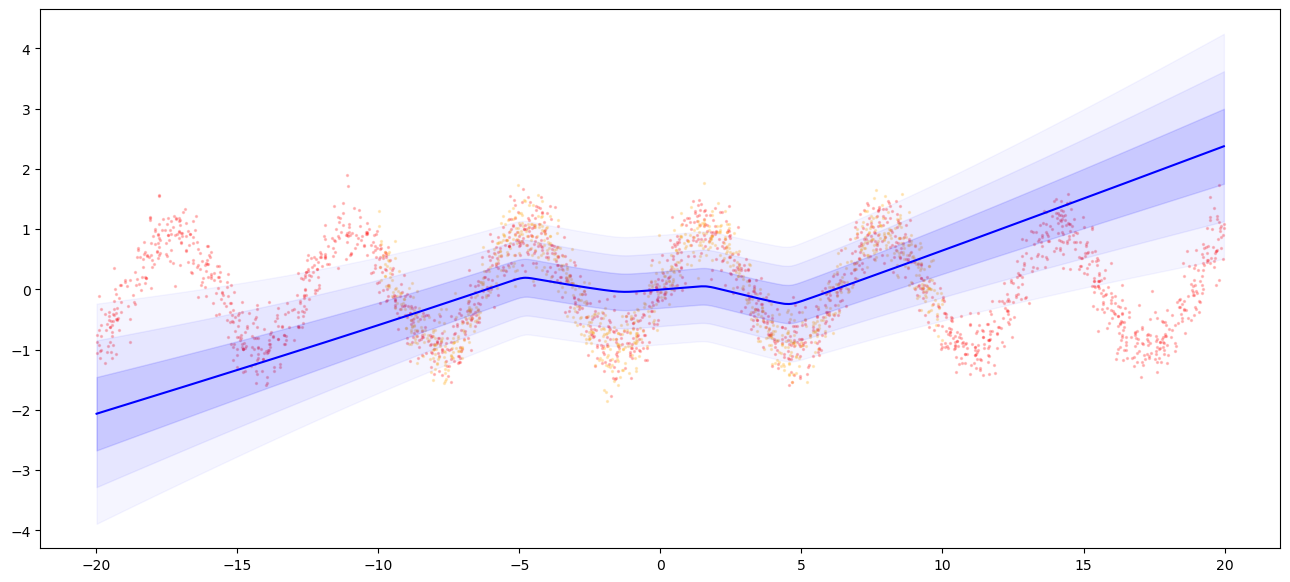

In [18]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    plt.plot(x_test[test_sort], means, color="blue")
    #plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
    for c in range(1, 4):
        plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

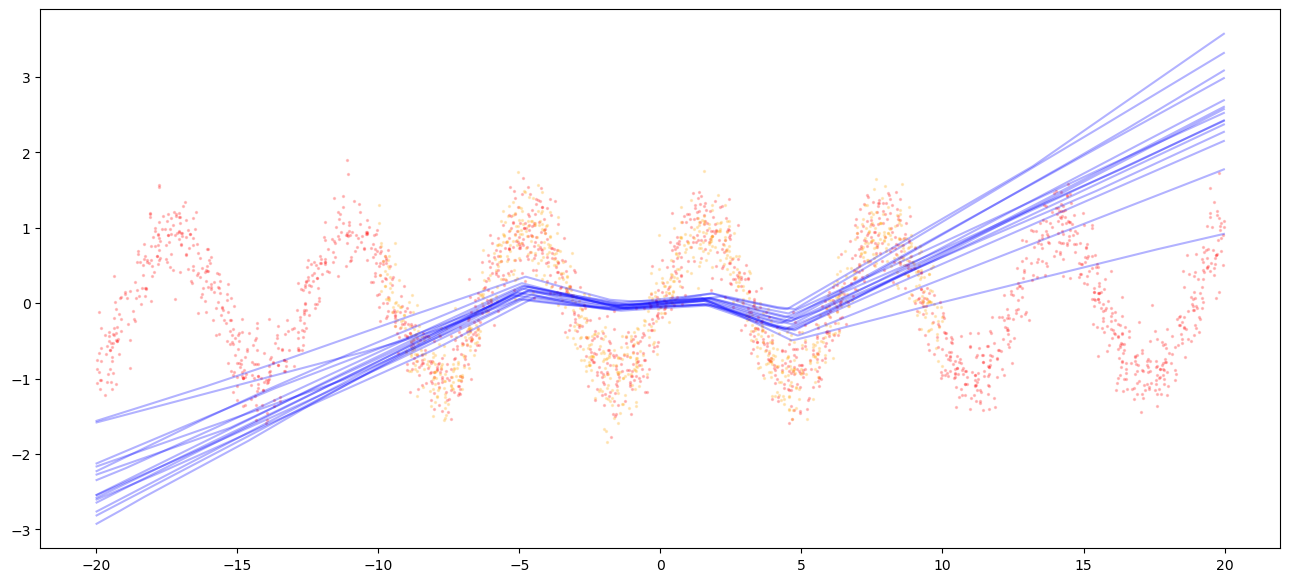

In [19]:
if dataset_config["X_DIM"] == "1":
    sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=15, aggregate=False)
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    for yhat in sampled_predictions:
        plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [20]:

if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None)

data samples:  (1000, 1000)
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.1 TRAIN_SIZE: 1000
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt
using device: cpu
====== evaluating profile tyxe-test - 1 ======
pred samples:  (1000, 1000)
Evaluating train...
Evaluating test...
Evaluating in_domain...
Evaluating out_domain...
Evaluating Uncertainty in train...
Evaluating Uncertainty in in_domain...
Evaluating Uncertainty in out_domain...
Eval done in 0:00:08.175743


In [21]:
profiles= [PROFILE]

colors = ["green"]

names = [configs[p]["NAME"] for p in profiles]

In [22]:
from IPython.display import display, HTML

train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats_1.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results_1.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

In [23]:
#Generate table for rmse
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train RMSE", "In domain RMSE", "Out domain RMSE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train RMSE": results[name]["train"]["error"]["rmse"],
        "In domain RMSE": results[name]["in_domain"]["error"]["rmse"],
        "Out domain RMSE": results[name]["out_domain"]["error"]["rmse"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for mae
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train MAE", "In domain MAE", "Out domain MAE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train MAE": results[name]["train"]["error"]["mae"],
        "In domain MAE": results[name]["in_domain"]["error"]["mae"],
        "Out domain MAE": results[name]["out_domain"]["error"]["mae"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for log likelihood
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train log likelihood", "In domain log likelihood", "Out domain log likelihood"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train log likelihood": results[name]["train"]["error"]["loglikelihood"],
        "In domain log likelihood": results[name]["in_domain"]["error"]["loglikelihood"],
        "Out domain log likelihood": results[name]["out_domain"]["error"]["loglikelihood"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)

/var/folders/3s/lr1yvkz14wxcwmg626sgr1th0000gn/T/ipykernel_81005/602405480.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({


,Name,Likelihood_std,Train RMSE,In domain RMSE,Out domain RMSE
0,tyxe-test,0.3,0.672859,0.682054,1.745357


/var/folders/3s/lr1yvkz14wxcwmg626sgr1th0000gn/T/ipykernel_81005/602405480.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({


,Name,Likelihood_std,Train MAE,In domain MAE,Out domain MAE
0,tyxe-test,0.3,0.572561,0.578226,1.547924


/var/folders/3s/lr1yvkz14wxcwmg626sgr1th0000gn/T/ipykernel_81005/602405480.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({


,Name,Likelihood_std,Train log likelihood,In domain log likelihood,Out domain log likelihood
0,tyxe-test,0.3,-1.968429,-2.02414,-6.089194


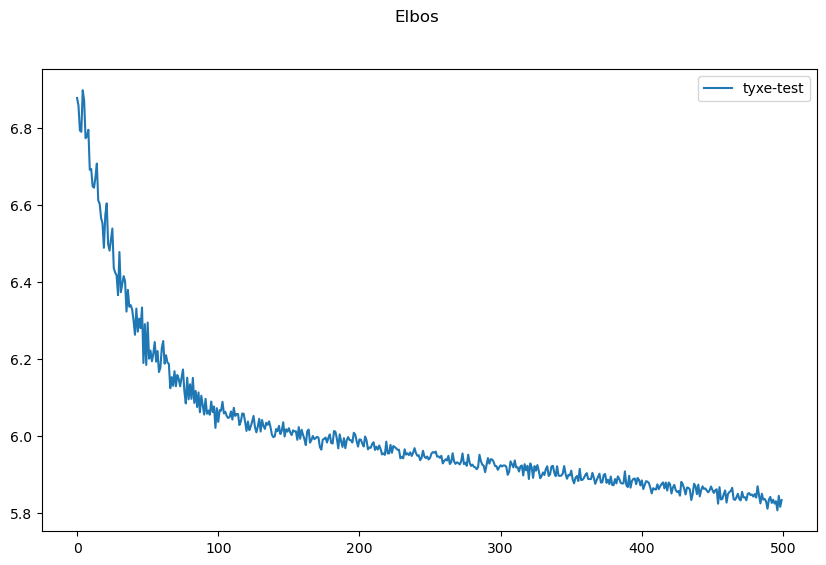

In [24]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Elbos")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["elbos"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("MSE loss")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["loss"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()


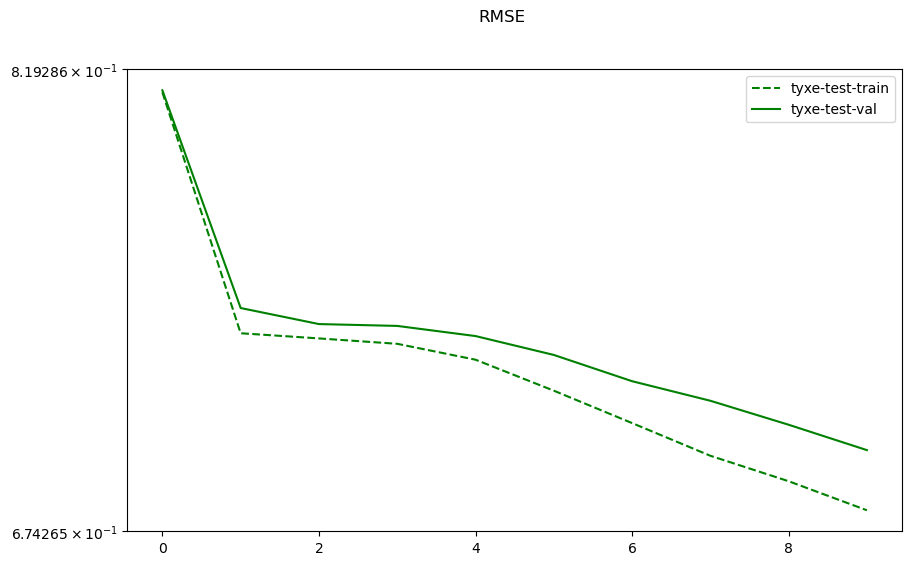

In [25]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("RMSE")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        te = train_stats[name]["train_rmse"]
        ax.plot(te, '--', label=f"{name}-train", color=colors[i])
        ve = train_stats[name]["val_rmse"]
        ax.plot(ve, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', base=10)
    ax.legend()
    plt.show()

TypeError: __init__() got an unexpected keyword argument 'basey'

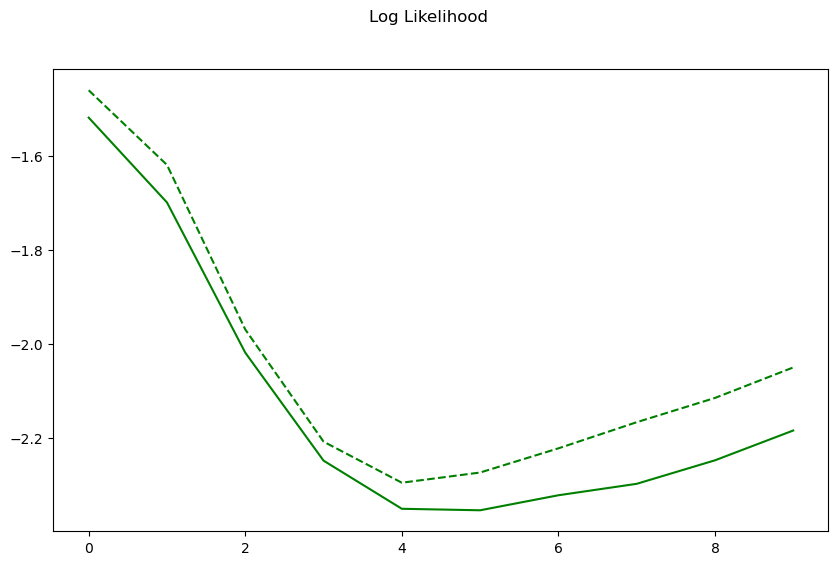

In [26]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Log Likelihood")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        tll = train_stats[name]["train_ll"]
        ax.plot(tll, '--', label=f"{name}-train", color=colors[i])
        vll = train_stats[name]["val_ll"]
        ax.plot(vll, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', basey=10)
    ax.legend()
    plt.show()

In [ ]:
name1 = configs[profiles[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}

In [ ]:
trace = poutine.trace(bnn.guide, param_only=True).get_trace(torch.ones(1, 1))
for name, value in trace.nodes.items():
    print(name, value["value"])

net_guide.net.0.weight.loc Parameter containing:
tensor([[ 0.0104],
        [-0.4800],
        [-0.7075],
        [-0.0014],
        [-0.2231],
        [-0.1603],
        [-0.1946],
        [ 0.0417],
        [ 0.0022],
        [ 0.1687],
        [ 0.0022],
        [ 0.1537],
        [ 0.2036],
        [-0.1851],
        [ 0.0037],
        [-0.1630],
        [-0.0191],
        [ 0.1852],
        [-0.3824],
        [-0.0121],
        [-0.2578],
        [ 0.2042],
        [ 0.1002],
        [-0.0973],
        [ 0.0053],
        [-0.1154],
        [-0.0114],
        [ 0.2338],
        [ 0.0332],
        [-0.0219],
        [-0.0841],
        [-0.0094]], requires_grad=True)
net_guide.net.0.weight.scale tensor([[0.0125],
        [0.0022],
        [0.0194],
        [0.0118],
        [0.0031],
        [0.0034],
        [0.0029],
        [0.0058],
        [0.0154],
        [0.0022],
        [0.0110],
        [0.0024],
        [0.0066],
        [0.0020],
        [0.0032],
        [0.0011],
     